## Library

In [1]:
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint
print('Loaded 1')

exec(open('utils.py').read())
print('Loaded 2')

exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')


Loaded 1
Loaded 2
Loaded TAI timelines module


## Variables

In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 40000                                      # Number of runs to do (default 10000)
CURRENT_YEAR = 2023                               # What year to start the run on? (default: 2023)
MAX_YEAR = 2123                                   # What year to end the run on? (default: 2123)
years = list(range(CURRENT_YEAR, MAX_YEAR))

In [3]:
tai_flop_size = sq.sample(load_cache_file='caches/meta_anchor')  # Cache generated in "Anchors" notebook
tai_flop_size = [round(t, 1) for t in tai_flop_size]
sq.get_percentiles(tai_flop_size)

{1: 22.0,
 5: 23.2,
 10: 24.2,
 20: 25.4,
 30: 26.9,
 40: 28.9,
 50: 30.9,
 60: 32.8,
 70: 34.9,
 80: 37.5,
 90: 40.9,
 95: 43.8,
 99: 49.50100000000002}

In [4]:
initial_pay = sq.sample(load_cache_file='caches/initial_pay')  # Cache generated in "Initial pay" notebook
initial_pay = [round(p, 1) for p in initial_pay]
# TODO: Suspicious this is not working in the model correctly
sq.get_percentiles(initial_pay)

{1: 7.0,
 5: 7.3,
 10: 7.4,
 20: 7.6,
 30: 7.8,
 40: 7.9,
 50: 8.0,
 60: 8.1,
 70: 8.3,
 80: 8.4,
 90: 8.7,
 95: 9.0,
 99: 9.4}

## Chance of nonscaling delay ##


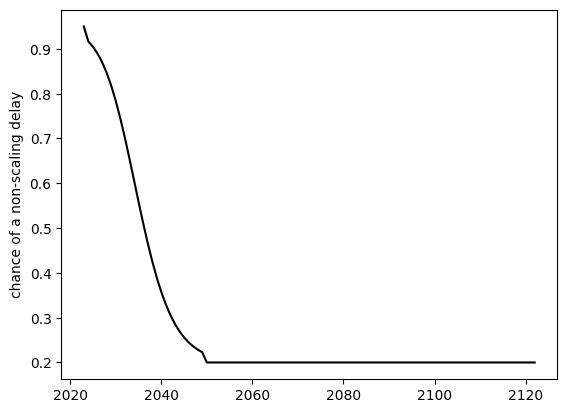

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 92%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 90%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 89%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 87%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 85%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 82%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 78%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 75%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2033

In [5]:
# PROBABILITY OF A NONSCALING DELAY
# Cache defined in "(3B) Nonscaling Delay Curve"
# Set p_delay_ = 0 if you do not want a nonscaling delay. Otherwise set this to the array of your choice.
# Note that the amount of years of delay is defined separately
with open('caches/nonscaling_delay_array.npy', 'rb') as f:
    p_delay_ = np.load(f)

print('## Chance of nonscaling delay ##')
plt.plot(years, p_delay_, color='black')
plt.ylabel('chance of a non-scaling delay')
plt.show()

for y in years[:10] + years[10::10]:
    outstr = 'Year: {} - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: {}%'
    print(outstr.format(y, int(round(p_delay_[y - CURRENT_YEAR] * 100))))


In [6]:
p_delay_

array([0.95      , 0.9164086 , 0.90478927, 0.88976383, 0.87068909,
       0.846986  , 0.81823998, 0.78431299, 0.74544278, 0.70229769,
       0.65595962, 0.60782596, 0.55944658, 0.51233465, 0.46779698,
       0.42681951, 0.39002206, 0.35767506, 0.32975843, 0.30603906,
       0.28614858, 0.26964961, 0.256086  , 0.24501687, 0.23603701,
       0.22878697, 0.22295612, 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2       ,
       0.2       , 0.2       , 0.2       , 0.2       , 0.2    

In [7]:
def wildeford_max_gdp_frac():
    small_project = sq.lognorm(1 / (250*K), 1 / (3*K))
    modern_megaproject = sq.lognorm(1/K, 1/600)
    old_form_megaproject = sq.lognorm(1/K, 1/150)
    gigaproject = sq.lognorm(1/150, 1/50)
    
    r_ = random.random()
    if r_ < 0.1:
        gdp_frac = small_project
        percent_spent_on_compute = sq.lognorm(0.5, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.7:
        gdp_frac = modern_megaproject
        percent_spent_on_compute = sq.lognorm(0.7, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.9:
        gdp_frac = old_form_megaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.95, lclip=0.1, rclip=0.999)
    else:
        gdp_frac = gigaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.99, lclip=0.1, rclip=0.999)
        
    models_trained_per_year_for_budget = sq.lognorm(1, 10)

    return ~gdp_frac * ~percent_spent_on_compute / ~models_trained_per_year_for_budget


variables = {'initial_gdp': 23*T,
             'tai_flop_size': tai_flop_size,
             'algo_doubling_rate_max': 3,
             'algo_doubling_rate_min': 1,
             'min_reduction': 2,
             'max_reduction': 5,
             'initial_flop_per_dollar': 18.3,
             'flop_halving_rate': sq.norm(2.5, 3),       # https://epochai.org/blog/predicting-gpu-performance
             'max_flop_per_dollar': sq.lognorm(21, 24),  # https://epochai.org/blog/predicting-gpu-performance
             'initial_pay': initial_pay,
             'gdp_growth': sq.lognorm(1.01, 1.035, lclip=1.005),
             'max_gdp_frac': wildeford_max_gdp_frac, # TODO: Willingness to spend connected to commercialization
             'spend_doubling_time': sq.norm(1.5, 4.5, lclip=1),
             'p_nonscaling_delay': p_delay_,
             'nonscaling_delay': sq.mixture([sq.lognorm(3, 10), sq.lognorm(10, 40)], weights=0.9)}

print('Loaded')


Loaded


## Run Wildeford timelines model

## RUN TIMELINES MODEL ##
Generating Bayes net with 6 cores...


40020it [02:50, 234.58it/s]                                                                          

Shuffling data...
Waiting for other cores...
.

..Collecting data...


100%|████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1139.86it/s]

...Collected!
Caching in-memory...
...Cached!
Writing cache to file `caches/tai_years.sqcache`...
...Cached!
...Reducing
...Reduced!
...All done!
-
## DISTRIBUTION OF TAI ARRIVAL DATE ##
['5%: 2027',
 '10%: 2028',
 '15%: 2028',
 '20%: 2029',
 '25%: 2030',
 '35%: 2032',
 '50%: 2040',
 '60%: 2048',
 '75%: 2102',
 '80%: >2123',
 '90%: >2123',
 '95%: >2123']
-
-
## DISTRIBUTION OF RELATIVE TAI ARRIVAL DATE ##
['5%: 4 years from now',
 '10%: 5 years from now',
 '15%: 5 years from now',
 '20%: 6 years from now',
 '25%: 7 years from now',
 '35%: 9 years from now',
 '50%: 17 years from now',
 '60%: 25 years from now',
 '75%: 79 years from now',
 '80%: >100 years from now',
 '90%: >100 years from now',
 '95%: >100 years from now']
-
-
## TAI ARRIVAL DATE BY BIN ##
This year: 1.9%
2024-2027: 2.4%
2028-2029: 18.7%
2030-2034: 16.9%
2035-2039: 8.8%
2040-2049: 12.3%
2050-2059: 7.7%
2060-2069: 3.3%
2070-2079: 1.4%
2080-2089: 0.8%
2090-2099: 0.5%
2100-2109: 0.5%
2110-2119: 0.5%
>2120: 24.2%
-
## TAI A

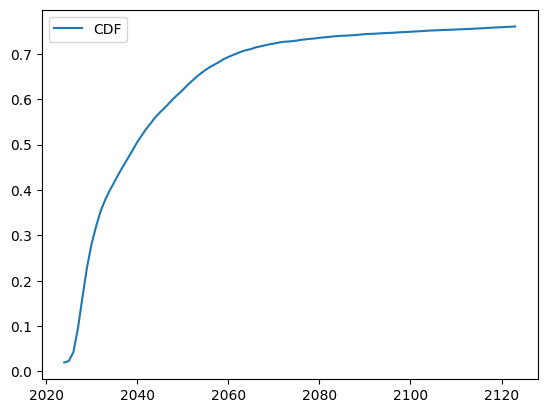

<string>:111: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<string>:112: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#d

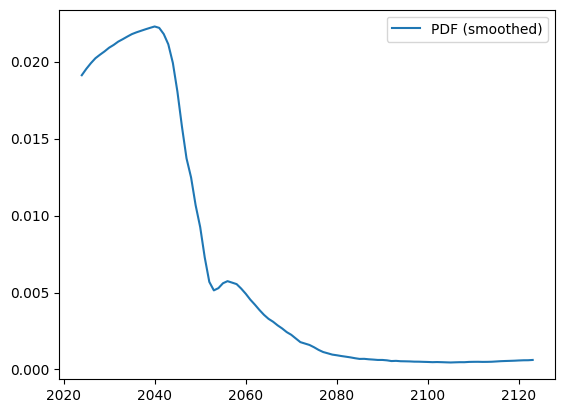

-
-
## TAI FLOP SIZE ##
{1: 22.0,
 5: 23.4,
 10: 24.2,
 20: 25.3,
 30: 27.0,
 40: 28.8,
 50: 30.5,
 60: 32.3,
 70: 34.6,
 80: 37.3,
 90: 40.4,
 95: 43.3,
 99: 49.0}


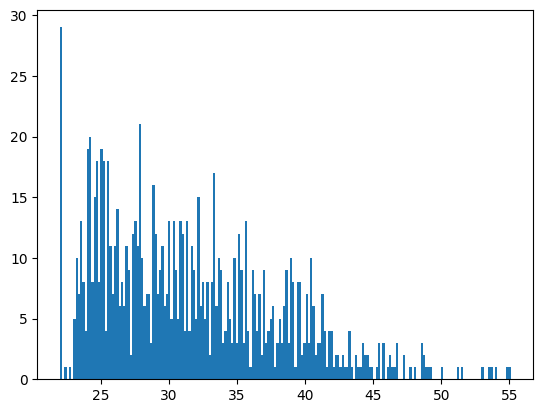

-
-
## MIN REDUCTION: 2 ##
-
## MAX REDUCTION: 5 ##
-
## MIN ALGO DOUBLING RATE: 1 ##
-
## MAX ALGO DOUBLING RATE: 3 ##
-
## INITIAL FLOP PER DOLLAR: 18.3 ##
-
## FLOP HALVING RATE ##
{1: 3.1,
 5: 3.0,
 10: 2.9,
 20: 2.9,
 30: 2.8,
 40: 2.8,
 50: 2.7,
 60: 2.7,
 70: 2.7,
 80: 2.6,
 90: 2.6,
 95: 2.5,
 99: 2.4}


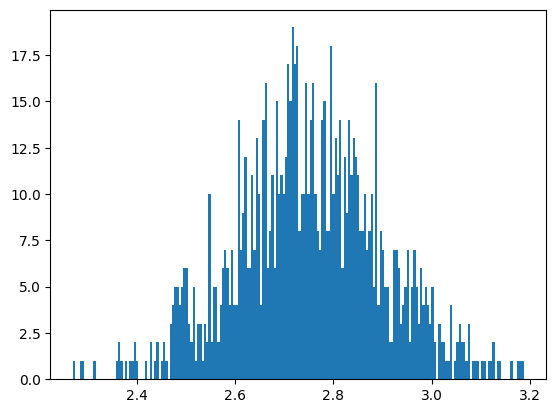

-
-
## MAX FLOP PER DOLLAR ##
{1: 20.5,
 5: 21.1,
 10: 21.4,
 20: 21.8,
 30: 22.1,
 40: 22.3,
 50: 22.5,
 60: 22.8,
 70: 23.1,
 80: 23.3,
 90: 23.7,
 95: 24.2,
 99: 24.6}


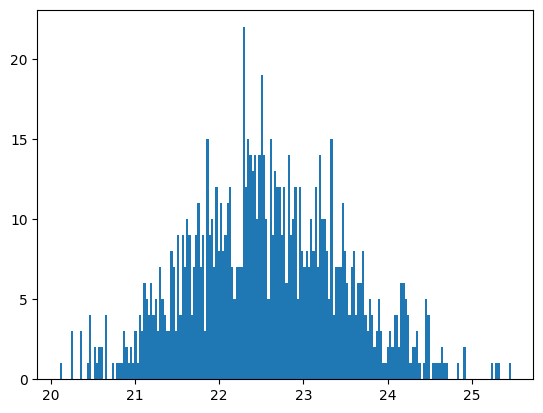

-
-
## INITIAL PAY ##
{1: 7.1,
 5: 7.3,
 10: 7.5,
 20: 7.6,
 30: 7.8,
 40: 7.9,
 50: 8.0,
 60: 8.1,
 70: 8.3,
 80: 8.4,
 90: 8.7,
 95: 8.9,
 99: 9.3}


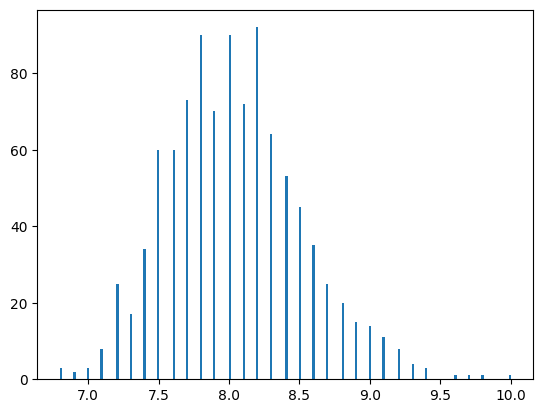

-
-
## GDP GROWTH ##
{1: 1.01,
 5: 1.01,
 10: 1.01,
 20: 1.02,
 30: 1.02,
 40: 1.02,
 50: 1.02,
 60: 1.02,
 70: 1.03,
 80: 1.03,
 90: 1.03,
 95: 1.04,
 99: 1.04}


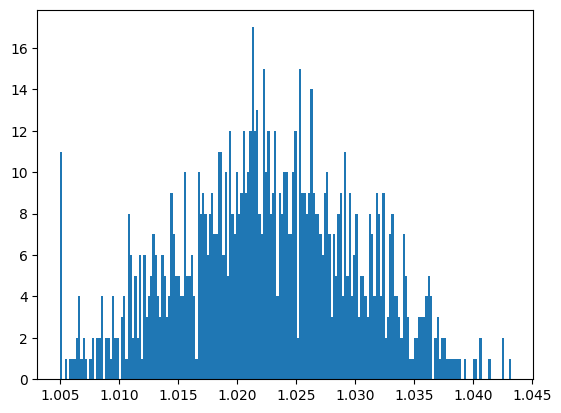

-
-
## MAX GDP FRAC ##
{1: 0.0,
 5: 1e-05,
 10: 6e-05,
 20: 0.00015,
 30: 0.00024,
 40: 0.00029,
 50: 0.00039,
 60: 0.00051,
 70: 0.00073,
 80: 0.00113,
 90: 0.00254,
 95: 0.00446,
 99: 0.00832}


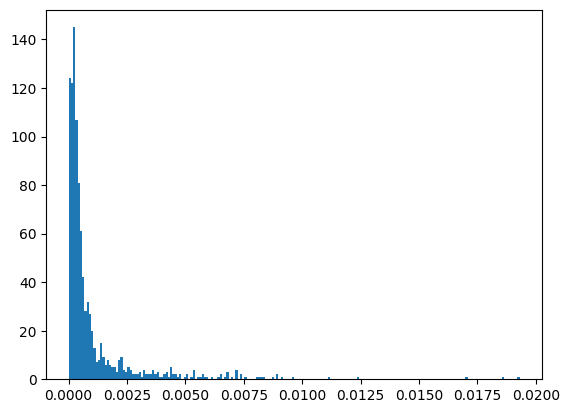

-
-
## NONSCALING DELAY ##
{1: 2,
 5: 3,
 10: 3,
 20: 4,
 30: 5,
 40: 5,
 50: 6,
 60: 6,
 70: 7,
 80: 9,
 90: 11,
 95: 21,
 99: 40}


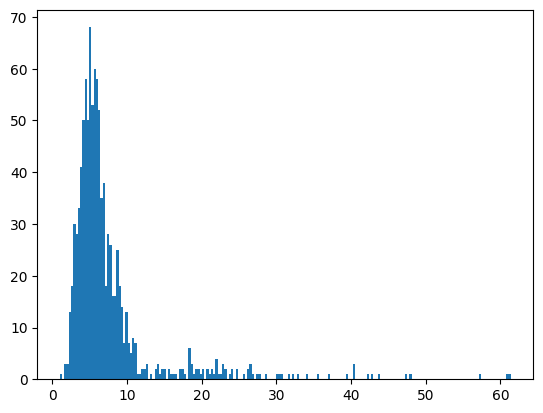

-
-
## SPEND DOUBLING TIME ##
{1: 5.0,
 5: 4.4,
 10: 4.1,
 20: 3.8,
 30: 3.5,
 40: 3.3,
 50: 3.1,
 60: 2.8,
 70: 2.6,
 80: 2.3,
 90: 1.9,
 95: 1.6,
 99: 1.0}


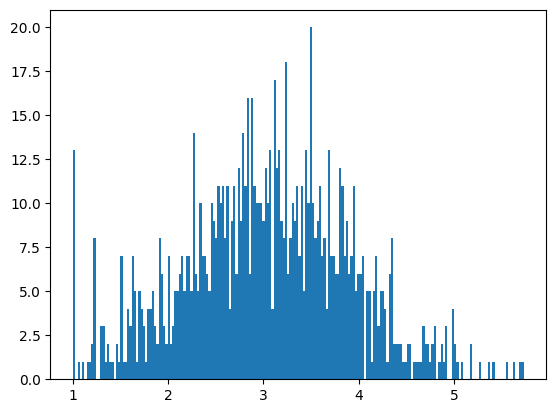

-
-
-
-
## GDP Over Time ##


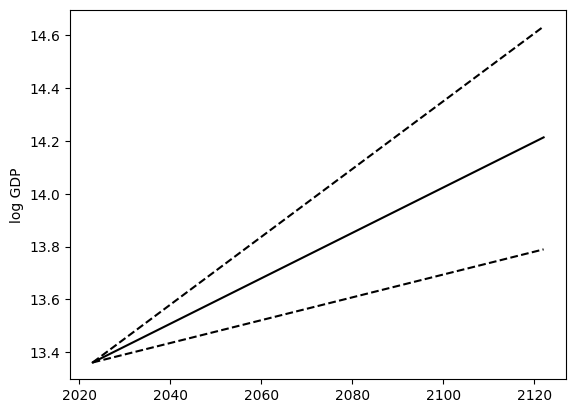

Year: 2023 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~23 trillion)
Year: 2024 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2025 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2026 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~25 trillion)
Year: 2027 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~26 trillion)
Year: 2028 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2029 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2030 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~28 trillion)
Year: 2031 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~29 trillion)
Year: 2032 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~30 trillion)
Year: 2033

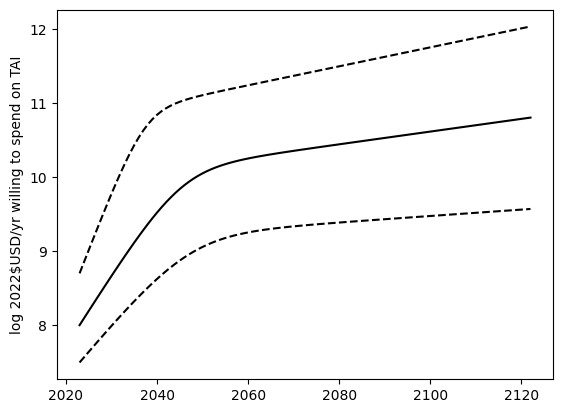

Year: 2023 - willingness log 2022$USD per year 8.0 (~99 million) 90% CI 7.5 (~31 million) - 8.7 (~497 million)
Year: 2024 - willingness log 2022$USD per year 8.1 (~123 million) 90% CI 7.6 (~36 million) - 8.9 (~713 million)
Year: 2025 - willingness log 2022$USD per year 8.2 (~154 million) 90% CI 7.6 (~43 million) - 9.0 (~1 billion)
Year: 2026 - willingness log 2022$USD per year 8.3 (~192 million) 90% CI 7.7 (~51 million) - 9.2 (~1 billion)
Year: 2027 - willingness log 2022$USD per year 8.4 (~239 million) 90% CI 7.8 (~60 million) - 9.3 (~2 billion)
Year: 2028 - willingness log 2022$USD per year 8.5 (~297 million) 90% CI 7.8 (~70 million) - 9.5 (~3 billion)
Year: 2029 - willingness log 2022$USD per year 8.6 (~369 million) 90% CI 7.9 (~82 million) - 9.6 (~4 billion)
Year: 2030 - willingness log 2022$USD per year 8.7 (~457 million) 90% CI 8.0 (~97 million) - 9.8 (~6 billion)
Year: 2031 - willingness log 2022$USD per year 8.8 (~566 million) 90% CI 8.1 (~113 million) - 9.9 (~8 billion)
Year: 

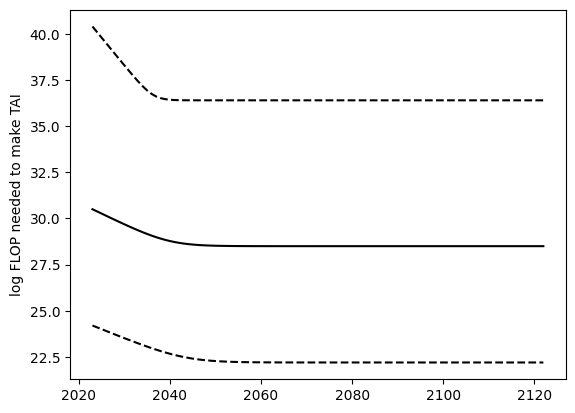

Year: 2023 - log FLOP needed for TAI 30.5 (~3 nonillion) 90% CI 24.2 (~2 septillion) - 40.4 (~25 million decillion)
Year: 2024 - log FLOP needed for TAI 30.4 (~2 nonillion) 90% CI 24.1 (~1 septillion) - 40.1 (~13 million decillion)
Year: 2025 - log FLOP needed for TAI 30.3 (~2 nonillion) 90% CI 24.0 (~1 septillion) - 39.8 (~6 million decillion)
Year: 2026 - log FLOP needed for TAI 30.1 (~1 nonillion) 90% CI 23.9 (~808 sextillion) - 39.5 (~3 million decillion)
Year: 2027 - log FLOP needed for TAI 30.0 (~1 nonillion) 90% CI 23.8 (~645 sextillion) - 39.2 (~2 million decillion)
Year: 2028 - log FLOP needed for TAI 29.9 (~822 octillion) 90% CI 23.7 (~515 sextillion) - 38.9 (~787 thousand decillion)
Year: 2029 - log FLOP needed for TAI 29.8 (~631 octillion) 90% CI 23.6 (~412 sextillion) - 38.6 (~395 thousand decillion)
Year: 2030 - log FLOP needed for TAI 29.7 (~486 octillion) 90% CI 23.5 (~330 sextillion) - 38.3 (~199 thousand decillion)
Year: 2031 - log FLOP needed for TAI 29.6 (~376 octil

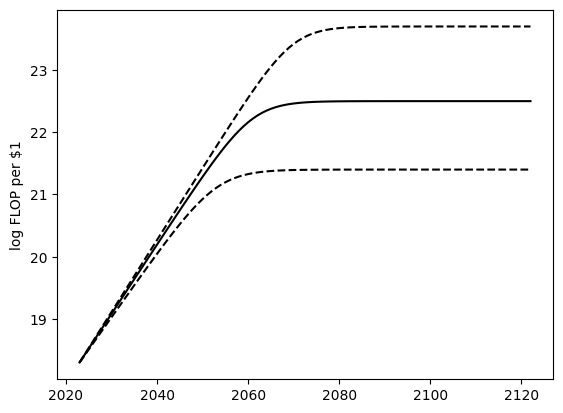

Year: 2023 - log FLOP per 2022$1USD 18.3 (~2 quintillion) 90% CI 18.3 (~2 quintillion) - 18.3 (~2 quintillion)
Year: 2024 - log FLOP per 2022$1USD 18.4 (~3 quintillion) 90% CI 18.4 (~3 quintillion) - 18.4 (~3 quintillion)
Year: 2025 - log FLOP per 2022$1USD 18.5 (~3 quintillion) 90% CI 18.5 (~3 quintillion) - 18.5 (~3 quintillion)
Year: 2026 - log FLOP per 2022$1USD 18.6 (~4 quintillion) 90% CI 18.6 (~4 quintillion) - 18.6 (~4 quintillion)
Year: 2027 - log FLOP per 2022$1USD 18.7 (~6 quintillion) 90% CI 18.7 (~5 quintillion) - 18.8 (~6 quintillion)
Year: 2028 - log FLOP per 2022$1USD 18.9 (~7 quintillion) 90% CI 18.8 (~7 quintillion) - 18.9 (~8 quintillion)
Year: 2029 - log FLOP per 2022$1USD 19.0 (~9 quintillion) 90% CI 18.9 (~8 quintillion) - 19.0 (~10 quintillion)
Year: 2030 - log FLOP per 2022$1USD 19.1 (~12 quintillion) 90% CI 19.0 (~11 quintillion) - 19.1 (~13 quintillion)
Year: 2031 - log FLOP per 2022$1USD 19.2 (~16 quintillion) 90% CI 19.1 (~13 quintillion) - 19.2 (~17 quintil

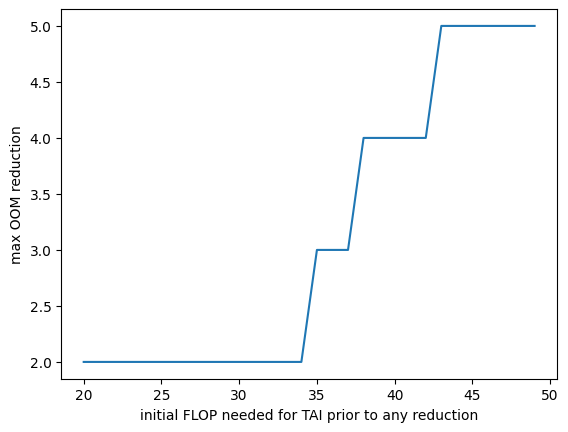

TAI log FLOP 20 -> 2.0 OOM reductions possible
TAI log FLOP 21 -> 2.0 OOM reductions possible
TAI log FLOP 22 -> 2.0 OOM reductions possible
TAI log FLOP 23 -> 2.0 OOM reductions possible
TAI log FLOP 24 -> 2.0 OOM reductions possible
TAI log FLOP 25 -> 2.0 OOM reductions possible
TAI log FLOP 26 -> 2.0 OOM reductions possible
TAI log FLOP 27 -> 2.0 OOM reductions possible
TAI log FLOP 28 -> 2.0 OOM reductions possible
TAI log FLOP 29 -> 2.0 OOM reductions possible
TAI log FLOP 30 -> 2.0 OOM reductions possible
TAI log FLOP 31 -> 2.0 OOM reductions possible
TAI log FLOP 32 -> 2.0 OOM reductions possible
TAI log FLOP 33 -> 2.0 OOM reductions possible
TAI log FLOP 34 -> 2.0 OOM reductions possible
TAI log FLOP 35 -> 3.0 OOM reductions possible
TAI log FLOP 36 -> 3.0 OOM reductions possible
TAI log FLOP 37 -> 3.0 OOM reductions possible
TAI log FLOP 38 -> 4.0 OOM reductions possible
TAI log FLOP 39 -> 4.0 OOM reductions possible
TAI log FLOP 40 -> 4.0 OOM reductions possible
TAI log FLOP 

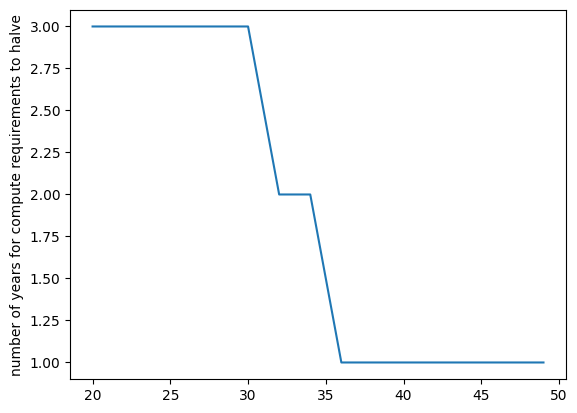

TAI log FLOP 20 -> algo doubling rate 3.0yrs
TAI log FLOP 21 -> algo doubling rate 3.0yrs
TAI log FLOP 22 -> algo doubling rate 3.0yrs
TAI log FLOP 23 -> algo doubling rate 3.0yrs
TAI log FLOP 24 -> algo doubling rate 3.0yrs
TAI log FLOP 25 -> algo doubling rate 3.0yrs
TAI log FLOP 26 -> algo doubling rate 3.0yrs
TAI log FLOP 27 -> algo doubling rate 3.0yrs
TAI log FLOP 28 -> algo doubling rate 3.0yrs
TAI log FLOP 29 -> algo doubling rate 3.0yrs
TAI log FLOP 30 -> algo doubling rate 3.0yrs
TAI log FLOP 31 -> algo doubling rate 2.5yrs
TAI log FLOP 32 -> algo doubling rate 2.0yrs
TAI log FLOP 33 -> algo doubling rate 2.0yrs
TAI log FLOP 34 -> algo doubling rate 2.0yrs
TAI log FLOP 35 -> algo doubling rate 1.5yrs
TAI log FLOP 36 -> algo doubling rate 1.0yrs
TAI log FLOP 37 -> algo doubling rate 1.0yrs
TAI log FLOP 38 -> algo doubling rate 1.0yrs
TAI log FLOP 39 -> algo doubling rate 1.0yrs
TAI log FLOP 40 -> algo doubling rate 1.0yrs
TAI log FLOP 41 -> algo doubling rate 1.0yrs
TAI log FL

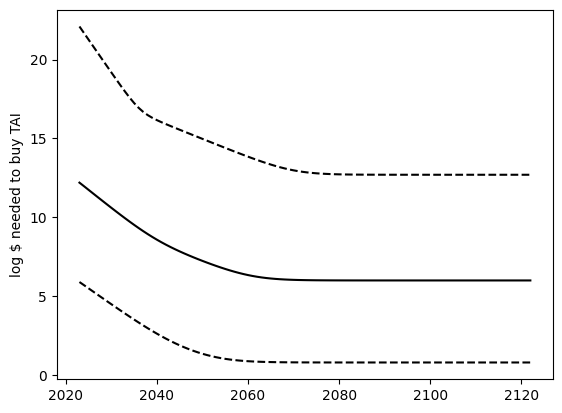

Year: 2023 - 12.2 log 2022$USD to buy TAI (~2 trillion) 90% CI 5.9 (~795 thousand) - 22.1 (~13 sextillion)
Year: 2024 - 12.0 log 2022$USD to buy TAI (~942 billion) 90% CI 5.7 (~503 thousand) - 21.7 (~5 sextillion)
Year: 2025 - 11.7 log 2022$USD to buy TAI (~554 billion) 90% CI 5.5 (~316 thousand) - 21.3 (~2 sextillion)
Year: 2026 - 11.5 log 2022$USD to buy TAI (~327 billion) 90% CI 5.3 (~198 thousand) - 20.8 (~708 quintillion)
Year: 2027 - 11.3 log 2022$USD to buy TAI (~193 billion) 90% CI 5.1 (~124 thousand) - 20.4 (~271 quintillion)
Year: 2028 - 11.1 log 2022$USD to buy TAI (~114 billion) 90% CI 4.9 (~78 thousand) - 20.0 (~104 quintillion)
Year: 2029 - 10.8 log 2022$USD to buy TAI (~68 billion) 90% CI 4.7 (~49 thousand) - 19.6 (~40 quintillion)
Year: 2030 - 10.6 log 2022$USD to buy TAI (~40 billion) 90% CI 4.5 (~31 thousand) - 19.2 (~15 quintillion)
Year: 2031 - 10.4 log 2022$USD to buy TAI (~24 billion) 90% CI 4.3 (~20 thousand) - 18.8 (~6 quintillion)
Year: 2032 - 10.2 log 2022$USD

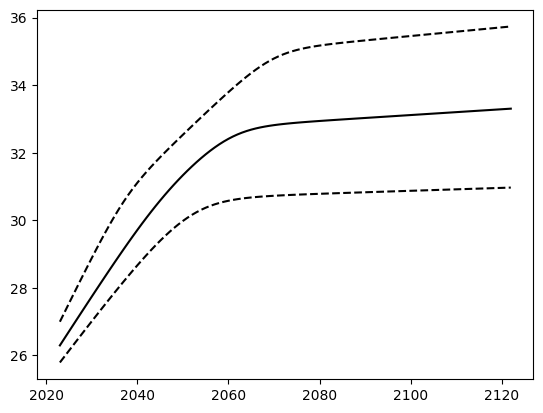

Year: 2023 - max log FLOP 26.3 (~197 septillion) 90% CI 25.8 (~62 septillion) - 27.0 (~991 septillion)
Year: 2024 - max log FLOP 26.5 (~318 septillion) 90% CI 26.0 (~92 septillion) - 27.3 (~2 octillion)
Year: 2025 - max log FLOP 26.7 (~513 septillion) 90% CI 26.1 (~138 septillion) - 27.5 (~3 octillion)
Year: 2026 - max log FLOP 26.9 (~826 septillion) 90% CI 26.3 (~207 septillion) - 27.8 (~6 octillion)
Year: 2027 - max log FLOP 27.1 (~1 octillion) 90% CI 26.5 (~309 septillion) - 28.1 (~12 octillion)
Year: 2028 - max log FLOP 27.3 (~2 octillion) 90% CI 26.7 (~461 septillion) - 28.4 (~22 octillion)
Year: 2029 - max log FLOP 27.5 (~3 octillion) 90% CI 26.8 (~687 septillion) - 28.6 (~42 octillion)
Year: 2030 - max log FLOP 27.7 (~5 octillion) 90% CI 27.0 (~1 octillion) - 28.9 (~76 octillion)
Year: 2031 - max log FLOP 27.9 (~9 octillion) 90% CI 27.2 (~2 octillion) - 29.1 (~139 octillion)
Year: 2032 - max log FLOP 28.1 (~14 octillion) 90% CI 27.4 (~2 octillion) - 29.4 (~250 octillion)
Year: 2

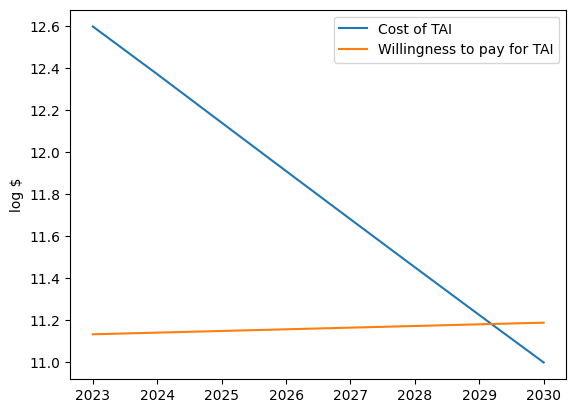

-
-
## SAMPLE RUN 2 ##
It takes 36.6 log FLOP (~4 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~7 sextillion) per 2022$USD.
We are willing to pay 32.9 log 2022$USD (~794 nonillion) and this doubles every 4.6 years to a max of 0.002264% of GDP. GDP grows at a rate of 1.015x per year.
If a non-scaling delay happens, it will take an additional 4.9 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2023 - 29.0 max log FLOP (104 octillion) available - TAI takes 36.6 log FLOP (4 thousand decillion) - log $ 18.3 to buy TAI (2 quintillion) vs. willingness to pay log $ 10.7 (52 billion) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 29.1 max log FLOP (134 octillion) available - TAI takes 36.3 log FLOP (2 thousand decillion) - log $ 17.9 to buy TAI (789 qua

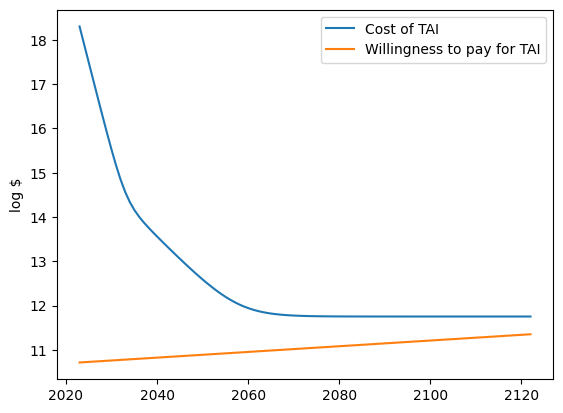

-
-
## SAMPLE RUN 3 ##
It takes 37.0 log FLOP (~10 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 21.0 log FLOP (~988 quintillion) per 2022$USD.
We are willing to pay 22.0 log 2022$USD (~10 sextillion) and this doubles every 3.6 years to a max of 0.00016% of GDP. GDP grows at a rate of 1.016x per year.
If a non-scaling delay happens, it will take an additional 5.4 years to produce TAI due to issues unrelated to scaling FLOP
---
Year: 2023 - 27.9 max log FLOP (7 octillion) available - TAI takes 37.0 log FLOP (10 thousand decillion) - log $ 18.7 to buy TAI (5 quintillion) vs. willingness to pay log $ 9.6 (4 billion) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 28.0 max log FLOP (9 octillion) available - TAI takes 36.7 log FLOP (5 thousand decillion) - log $ 18.3 to buy TAI (2 quintil

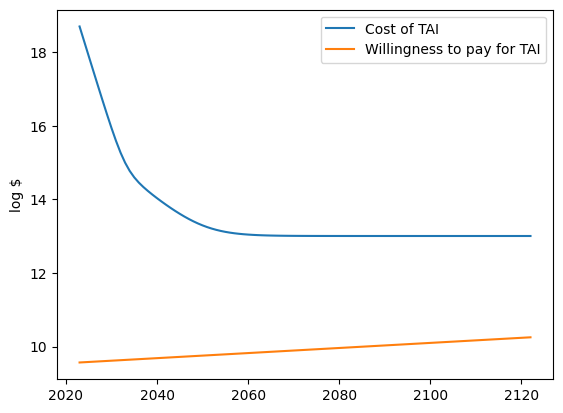

In [8]:
run_timelines_model(variables, cores=6, runs=RUNS, dump_cache_file='caches/tai_years')